<a href="https://colab.research.google.com/github/divyking52/action_recognition/blob/master/Foodvision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-b5cf2eac-4e4b-063d-e209-85da9e44dfc5)


In [ ]:
##get helper functions

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-11-08 05:02:03--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-11-08 05:02:03 (97.1 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys


In [ ]:
import tensorflow_datasets as tfds

In [ ]:
(train_data, test_data), ds_info = tfds.load(name ="food101",
                                             split=["train", "validation"],
                                             shuffle_files = True,
                                             as_supervised = True,
                                             with_info = True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteIK6L0J/food101-train.tfrecord*...:   0%|          …

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteIK6L0J/food101-validation.tfrecord*...:   0%|     …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [ ]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [ ]:
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [ ]:
import tensorflow as tf

In [ ]:
#making preprocessing functions
def preprocess(image, label, img_shape=224):
  image = tf.image.resize(image, [img_shape, img_shape])
  return tf.cast(image, tf.float32), label

In [ ]:
##batch and dataset
## map preprocessing function to training (and parallelize)

train_data = train_data.map(map_func= preprocess, num_parallel_calls = tf.data.AUTOTUNE)

## shuffle train_data and turn it into batches and prefetch it (load it normally)

train_data = train_data.shuffle(buffer_size = 1000).batch(batch_size = 32).prefetch(buffer_size=tf.data.AUTOTUNE)

test_data = test_data.map(preprocess, num_parallel_calls = tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)


In [ ]:
from helper_functions import create_tensorboard_callback

checkpoint_path ="model_checkpoints/cp.ckpt"
model_checkpoint =tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                     monitor ="val_acc",
                                                     save_best_only=True,
                                                     save_weights_only=True,
                                                    verbose=0  )

In [ ]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

input_shape = (224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False


inputs = layers.Input(shape= input_shape, name = "input_layer")

x= base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x)

outputs = layers.Activation("softmax", dtype=tf.float32, name ="softmax_float32")(x)
model = tf.keras.Model(inputs, outputs)


model.compile(loss="sparse_categorical_crossentropy",
              optimizer = tf.keras.optimizers.Adam(),
              metrics=["accuracy"])



In [ ]:
len(class_names)

101

In [ ]:
food_101_features= model.fit(train_data,
                             epochs= 3,
                             steps_per_epoch=(len(train_data)),
                             validation_data = test_data,
                             validation_steps=(0.15 * len(test_data)),
                             callbacks = [create_tensorboard_callback(dir_name="training_logs",
                                                                      experiment_name='efficientnetb0_101_classes_all_data_feature_extract'),
                                          model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientnetb0_101_classes_all_data_feature_extract/20231108-051810
Epoch 1/3
2368/2368 [==============================] - ETA: 0s - loss: 1.7170 - accuracy: 0.5828

2368/2368 [==============================] - 196s 75ms/step - loss: 1.7170 - accuracy: 0.5828 - val_loss: 1.1249 - val_accuracy: 0.6925
Epoch 2/3
2367/2368 [============================>.] - ETA: 0s - loss: 1.1985 - accuracy: 0.6881

2368/2368 [==============================] - 176s 73ms/step - loss: 1.1985 - accuracy: 0.6881 - val_loss: 1.0298 - val_accuracy: 0.7174
Epoch 3/3
2368/2368 [==============================] - ETA: 0s - loss: 1.0531 - accuracy: 0.7243

2368/2368 [==============================] - 177s 74ms/step - loss: 1.0531 - accuracy: 0.7243 - val_loss: 1.0036 - val_accuracy: 0.7198


In [ ]:
results_feature_extract_model = model.evaluate(test_data)
results_feature_extract_model

790/790 [==============================] - 53s 67ms/step - loss: 0.9938 - accuracy: 0.7295


[0.9937849044799805, 0.7295445799827576]

1/1 [==============================] - 0s 34ms/step


ValueError: ignored

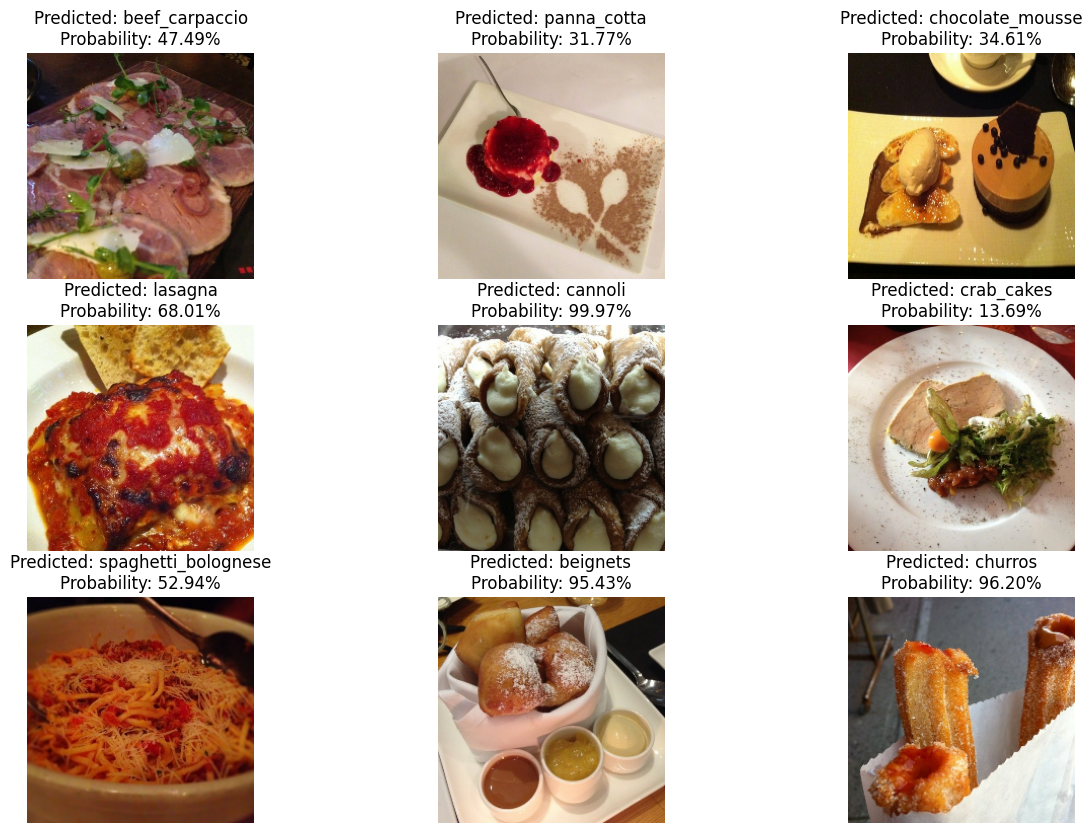

In [ ]:
import numpy as np

import matplotlib.pyplot as plt

# Define a function to make predictions and visualize the results
def make_predictions_and_visualize(model, images, class_names):
    # Get predicted probabilities for each class
    predictions = model.predict(images)

    # Map predicted probabilities to class names
    predicted_labels = [class_names[i] for i in np.argmax(predictions, axis=1)]

    # Visualize the predictions
    plt.figure(figsize=(15, 10))
    for i in range(len(images)):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"Predicted: {predicted_labels[i]}\nProbability: {np.max(predictions[i]) * 100:.2f}%")
        plt.axis('off')
    plt.show()

# Assuming you have a batch of test images (X_test)
test_images, true_labels = next(iter(test_data))  # Assuming you want to make predictions on a batch of test data

# Make predictions and visualize
make_predictions_and_visualize(model, test_images, class_names)


In [ ]:
model.save("foodvision.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from google.colab import files

files.download("foodvision.h5")  # Replace with the file name you used for saving


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

ValueError: ignored

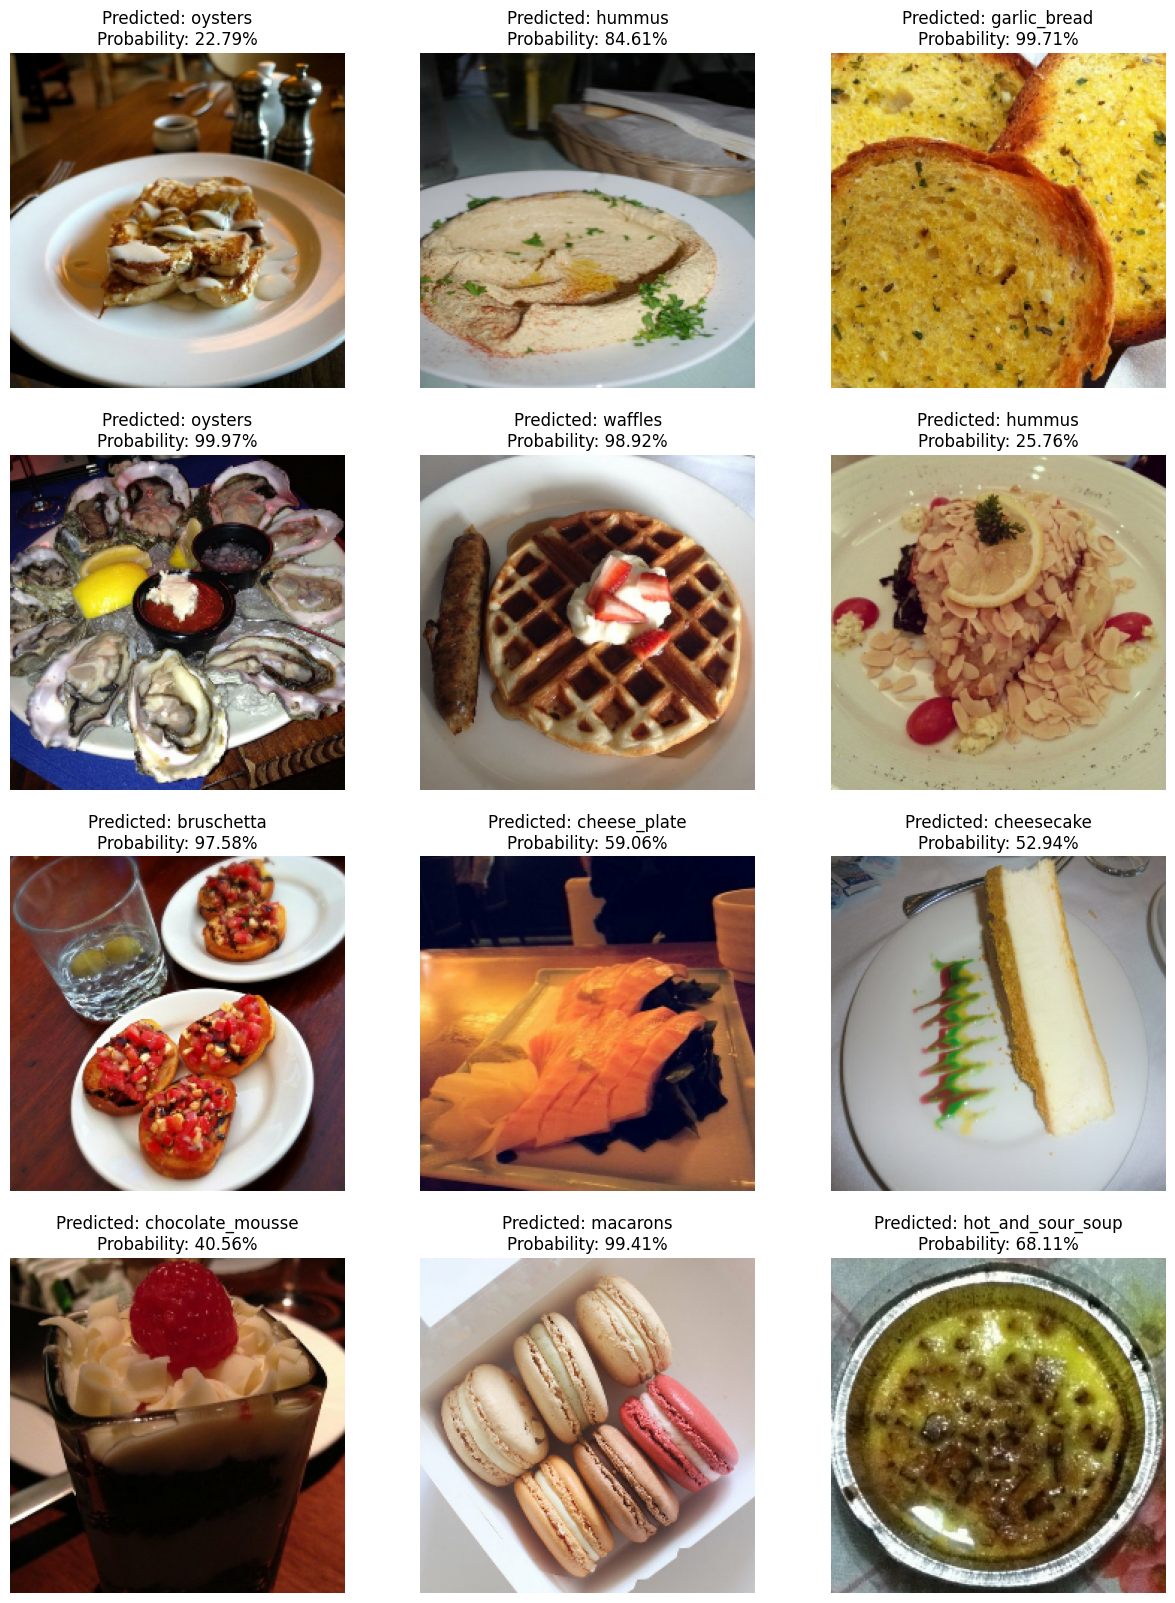

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define a function to make predictions and visualize the results
def make_predictions_and_visualize(model, images, class_names):
    num_images = len(images)
    rows, cols = 4, 3  # Define the number of rows and columns for subplots (e.g., a 4x3 grid)

    plt.figure(figsize=(15, 20))  # Adjust the figure size to accommodate the new grid size

    for i in range(num_images):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"Predicted: {predicted_labels[i]}\nProbability: {np.max(predictions[i]) * 100:.2f}%")
        plt.axis('off')

    plt.tight_layout()  # Ensure proper spacing between subplots
    plt.show()

# Assuming you have a batch of test images (X_test)
test_images, true_labels = next(iter(test_data))  # Assuming you want to make predictions on a batch of test data

# Make predictions and visualize
make_predictions_and_visualize(model, test_images, class_names)
